# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [7]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [8]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [9]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [10]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

In [11]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))

In [12]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|
+------+---+------+---+-------+-------------------+---+----+------+
only showing top 5 rows



# IP Number of Clicks for same App in same Hour

In [13]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

In [14]:
var = 'app'

In [15]:
var_hour_clicks = (data
                   .groupBy(var, 'day', 'hour')
                   .agg(func.count(func.lit(1)).alias(var+'_hour_clicks'),
                        func.round(func.stddev(col('minute')), 2).alias(var+'_hour_std_minute'),
                        func.round(func.mean(col('minute')), 2).alias(var+'_hour_avg_minute'))
                      .fillna({var+'_hour_std_minute':0,
                               var+'_hour_avg_minute':0})
                      .cache())

var_hour_clicks.show(100, truncate=False)

+---+---+----+---------------+-------------------+-------------------+
|app|day|hour|app_hour_clicks|app_hour_std_minute|app_hour_avg_minute|
+---+---+----+---------------+-------------------+-------------------+
|183|07 |03  |894            |17.5               |37.56              |
|128|07 |00  |29             |18.04              |31.07              |
|115|07 |10  |65             |15.04              |34.09              |
|150|07 |10  |1937           |16.33              |12.4               |
|193|07 |10  |9              |16.55              |30.56              |
|567|07 |10  |1              |0.0                |45.0               |
|27 |07 |17  |6533           |17.18              |26.97              |
|310|07 |17  |50             |7.02               |15.44              |
|175|07 |18  |5              |11.55              |23.0               |
|247|07 |20  |1              |0.0                |58.0               |
|143|07 |21  |1              |0.0                |32.0               |
|45 |0

In [16]:
data.filter((col('hour')==22) & (col(var)==76)).show(truncate=False)

+------+---+------+---+-------+-------------------+---+----+------+
|ip    |app|device|os |channel|click_time         |day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
|60725 |76 |3032  |607|347    |2017-11-06 22:27:36|06 |22  |27    |
|85120 |76 |3032  |607|347    |2017-11-06 22:30:28|06 |22  |30    |
|75090 |76 |3032  |607|347    |2017-11-06 22:36:24|06 |22  |36    |
|165408|76 |3032  |607|347    |2017-11-06 22:42:41|06 |22  |42    |
|108913|76 |3032  |607|347    |2017-11-06 22:49:13|06 |22  |49    |
|5348  |76 |3543  |748|347    |2017-11-07 22:11:46|07 |22  |11    |
|53454 |76 |3543  |748|347    |2017-11-07 22:27:11|07 |22  |27    |
|20072 |76 |3543  |748|347    |2017-11-07 22:29:58|07 |22  |29    |
|274299|76 |3543  |748|347    |2017-11-07 22:31:35|07 |22  |31    |
|5348  |76 |3543  |748|347    |2017-11-07 22:36:34|07 |22  |36    |
|100045|76 |1     |13 |347    |2017-11-07 22:39:53|07 |22  |39    |
|105560|76 |3543  |748|347    |2017-11-07 22:53:

In [17]:
hour_clicks = (data
               .groupBy('day', 'hour')
               .agg(func.count(func.lit(1)).alias('hour_clicks'),
                    func.round(func.stddev(col('minute')), 2).alias('hour_std_minute'),
                    func.round(func.mean(col('minute')), 2).alias('hour_avg_minute'))
               .fillna({'hour_std_minute':0,
                        'hour_avg_minute':0})
               .cache())

hour_clicks.show(100, truncate=False)

+---+----+-----------+---------------+---------------+
|day|hour|hour_clicks|hour_std_minute|hour_avg_minute|
+---+----+-----------+---------------+---------------+
|07 |20  |409255     |17.48          |29.26          |
|10 |16  |290        |0.0            |0.0            |
|08 |16  |2455567    |17.35          |26.86          |
|08 |13  |3616634    |17.36          |29.46          |
|07 |19  |493056     |17.33          |27.82          |
|10 |08  |2878913    |17.31          |29.8           |
|10 |01  |2821678    |17.4           |29.33          |
|06 |21  |509572     |17.69          |31.55          |
|07 |00  |3604365    |17.01          |29.6           |
|09 |10  |3304199    |17.35          |29.7           |
|09 |21  |571504     |17.5           |31.52          |
|09 |12  |3363917    |17.34          |29.54          |
|08 |05  |3160269    |17.4           |28.88          |
|08 |22  |1260525    |17.08          |33.49          |
|10 |03  |2850281    |17.58          |30.21          |
|08 |12  |

## Export New Features

In [19]:
(var_hour_clicks
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_"+var+"_hour_clicks", compression="None"))

In [18]:
var_hour_clicks.count()

46317015

## Check the impact of new features

In [21]:
import pyspark.sql.functions as func

train.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002470721410998979|
+--------------------+



In [18]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .withColumn('day', day_udf(data.click_time))
                .withColumn('hour', hour_udf(data.click_time))
                .join(var_hour_clicks, [var, 'day', 'hour'], 'left_outer')
                .join(hour_clicks, ['day', 'hour'], 'left_outer')
                .withColumn(var+'_hour_click_percentage', func.round(col(var+'_hour_clicks') / col('hour_clicks'),6))
                .cache())

In [19]:
train_sample.count()

9248009

In [20]:
train.sample(fraction=0.05, withReplacement=False, seed=22).count()

9248009

In [21]:
train_sample.show(5, truncate=False)

+---+----+---+------+------+---+-------+-------------------+---------------+-------------+---------------+-------------------+-------------------+-----------+---------------+---------------+-------------------------+
|day|hour|app|ip    |device|os |channel|click_time         |attributed_time|is_attributed|app_hour_clicks|app_hour_std_minute|app_hour_avg_minute|hour_clicks|hour_std_minute|hour_avg_minute|app_hour_click_percentage|
+---+----+---+------+------+---+-------+-------------------+---------------+-------------+---------------+-------------------+-------------------+-----------+---------------+---------------+-------------------------+
|06 |14  |3  |38816 |1     |18 |379    |2017-11-06 14:40:39|null           |0            |43             |7.84               |45.98              |48         |7.86           |45.83          |0.895833                 |
|06 |14  |3  |134575|1     |13 |379    |2017-11-06 14:43:10|null           |0            |43             |7.84               |45.98 

In [22]:
features = [var+'_hour_clicks', var+'_hour_std_minute', var+'_hour_avg_minute', var+'_hour_click_percentage']

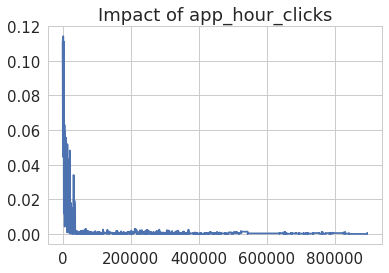

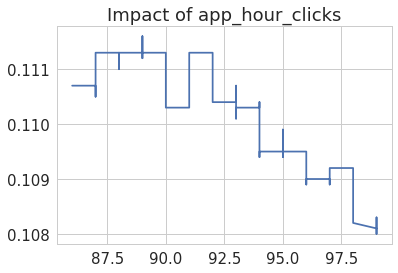

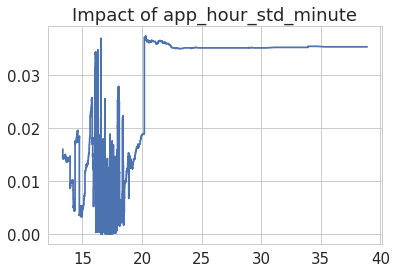

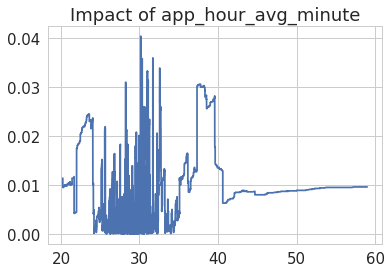

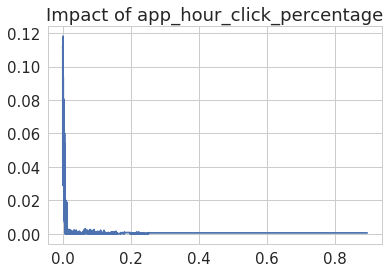

In [23]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()

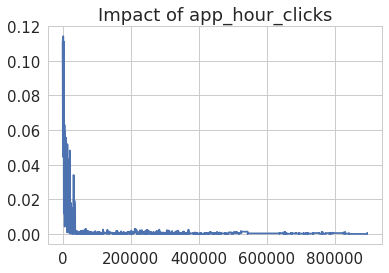

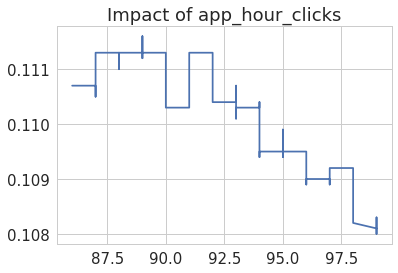

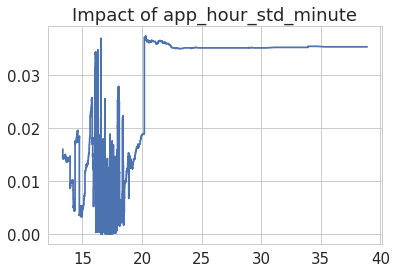

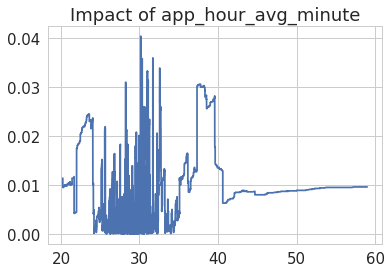

In [22]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()